CT Training and Reconstructions with ODP
========================================

This example demonstrates the training of the unrolled
optimization with deep priors (ODP) gradient descent architecture
described in <cite data-cite="diamond-2018-odp"/> applied to a CT reconstruction problem.

The source images are foam phantoms generated with xdesign.

A class [scico.flax.ODPNet](../_autosummary/scico.flax.rst#scico.flax.ODPNet)
implements the ODP architecture, which solves the optimization problem

  $$\mathrm{argmin}_{\mathbf{x}} \; \| A \mathbf{x} - \mathbf{y} \|_2^2 + r(\mathbf{x}) \;,$$

where $A$ is a tomographic projector, $\mathbf{y}$ is a set of sinograms, $r$ is a regularizer
and $\mathbf{x}$ is the set of reconstructed images. The ODP, gradient descent architecture,
abstracts the iterative solution by an unrolled network where each iteration corresponds
to a different stage in the ODP network and updates the prediction by solving

  $$\mathbf{x}^{k+1} = \mathrm{argmin}_{\mathbf{x}} \; \alpha_k \| A \mathbf{x} - \mathbf{y} \|_2^2 + \frac{1}{2} \| \mathbf{x} - \mathbf{x}^k - \mathbf{x}^{k+1/2} \|_2^2 \;,$$

which for the CT problem, using gradient descent, corresponds to

  $$\mathbf{x}^{k+1} = \mathbf{x}^k + \mathbf{x}^{k+1/2} -  \alpha_k \, A^T \, (A \mathbf{x}^k - \mathbf{y}) \;,$$

where $k$ is the index of the stage (iteration),
$\mathbf{x}^k + \mathbf{x}^{k+1/2} = \mathrm{ResNet}(\mathbf{x}^{k})$
is the regularization (implemented as a residual convolutional neural network),
 $\mathbf{x}^k$ is the output of the previous stage and
 $\alpha_k > 0$ is a learned stage-wise parameter weighting the contribution of the fidelity term.
 The output of the final stage is the set of reconstructed images.

In [1]:
import os
from functools import partial
from time import time

import numpy as np

import jax

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scico import flax as sflax
from scico import metric, plot
from scico.flax.examples import load_ct_data
from scico.flax.train.traversals import clip_positive, construct_traversal
from scico.linop.radon_astra import TomographicProjector
plot.config_notebook_plotting()

Prepare parallel processing. Set an arbitrary processor
count (only applies if GPU is not available).

In [2]:
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
platform = jax.lib.xla_bridge.get_backend().platform
print("Platform: ", platform)

Platform:  gpu


Read data from cache or generate if not available.

In [3]:
N = 256  # phantom size
train_nimg = 536  # number of training images
test_nimg = 64  # number of testing images
nimg = train_nimg + test_nimg
n_projection = 45  # CT views

trdt, ttdt = load_ct_data(train_nimg, test_nimg, N, n_projection, verbose=True)

Data read from path       :   ~/.cache/scico/examples/data
Set --training--          :   Size:   536
Set --testing --          :   Size:   64
Data range --images  --   :    Min:   0.00, Max: 1.00
Data range --sinogram--   :    Min:   0.00, Max: 0.67
Data range --FBP     --   :    Min:   0.00, Max: 1.00


Build CT projection operator.

In [4]:
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
A = TomographicProjector(
    input_shape=(N, N),
    detector_spacing=1,
    det_count=N,
    angles=angles,
)  # Radon transform operator
A = (1.0 / N) * A  # normalized

Build training and testing structures. Inputs are the sinograms and
outpus are the original generated foams. Keep training and testing
partitions.

In [5]:
numtr = 320
numtt = 32
train_ds = {"image": trdt["sino"][:numtr], "label": trdt["img"][:numtr]}
test_ds = {"image": ttdt["sino"][:numtt], "label": ttdt["img"][:numtt]}

Define configuration dictionary for model and training loop.

Parameters have been selected for demonstration purposes and relatively short training.
The model depth is akin to the number of unrolled iterations in the MoDL model.
The block depth controls the number of layers at each unrolled iteration.
The number of filters is uniform throughout the iterations.
The iterations used for the conjugate gradient (CG) solver can also be specified.
Better performance may be obtained by increasing depth, block depth, number of filters, CG iterations, or training epochs,
but may require longer training times.

In [6]:
# model configuration
model_conf = {
    "depth": 8,
    "num_filters": 64,
    "block_depth": 6,
}
# training configuration
train_conf: sflax.ConfigDict = {
    "seed": 1234,
    "opt_type": "ADAM",
    "batch_size": 16,
    "num_epochs": 200,
    "base_learning_rate": 1e-3,
    "warmup_epochs": 0,
    "log_every_steps": 160,
    "log": True,
}

Construct functionality for making sure that
the learned fidelity weight parameter is always
positive.

In [7]:
alphatrav = construct_traversal("alpha")  # select alpha parameters in model
alphapost = partial(
    clip_positive,  # apply this function
    traversal=alphatrav,  # to alpha parameters in model
    minval=1e-3,
)

Print configuration of distributed run.

In [8]:
print(f"{'JAX process: '}{jax.process_index()}{' / '}{jax.process_count()}")
print(f"{'JAX local devices: '}{jax.local_devices()}")

JAX process: 0 / 1
JAX local devices: [GpuDevice(id=0, process_index=0), GpuDevice(id=1, process_index=0), GpuDevice(id=2, process_index=0), GpuDevice(id=3, process_index=0), GpuDevice(id=4, process_index=0), GpuDevice(id=5, process_index=0), GpuDevice(id=6, process_index=0), GpuDevice(id=7, process_index=0)]


Construct ODPNet model.

In [9]:
channels = train_ds["image"].shape[-1]
model = sflax.ODPNet(
    operator=A,
    depth=model_conf["depth"],
    channels=channels,
    num_filters=model_conf["num_filters"],
    block_depth=model_conf["block_depth"],
    odp_block=sflax.ODPGrDescBlock,
    alpha_ini=1e-2,
)

Run training loop.

In [10]:
workdir = os.path.join(os.path.expanduser("~"), ".cache", "scico", "examples", "odp_ct_out")

train_conf["workdir"] = workdir
train_conf["post_lst"] = [alphapost]
# Construct training object
trainer = sflax.BasicFlaxTrainer(
    train_conf,
    model,
    train_ds,
    test_ds,
)

start_time = time()
modvar, stats_object = trainer.train()
time_train = time() - start_time

Channels: 1, training signals: 320, testing signals: 32, signal size: 256


+---------------------------------------------------------+----------------+--------+-----------+--------+
| Name                                                    | Shape          | Size   | Mean      | Std    |
+---------------------------------------------------------+----------------+--------+-----------+--------+
| ODPGrDescBlock_0/alpha                                  | (1,)           | 1      | 0.01      | 0.0    |
| ODPGrDescBlock_0/resnet/BatchNorm_0/bias                | (1,)           | 1      | 0.0       | 0.0    |
| ODPGrDescBlock_0/resnet/BatchNorm_0/scale               | (1,)           | 1      | 1.0       | 0.0    |
| ODPGrDescBlock_0/resnet/ConvBNBlock_0/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ODPGrDescBlock_0/resnet/ConvBNBlock_0/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ODPGrDescBlock_0/resnet/ConvBNBlock_0/Conv_0/kernel     | (3, 3, 1, 64)  | 576    | -0.000308 | 0.0568 |
| ODPGrDescBlock_0/resnet/ConvBNBlock

Initial compilation, this might take some minutes...


2023-01-26 15:59:02.069329: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[3,3,64,64]{1,0,2,3}, u8[0]{0}) custom-call(f32[2,258,258,64]{2,1,3,0}, f32[2,256,256,64]{2,1,3,0}), window={size=3x3}, dim_labels=b01f_01io->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


Initial compilation completed.


Epoch  Time      Train_LR  Train_Loss  Train_SNR  Eval_Loss  Eval_SNR
---------------------------------------------------------------------
    7  2.27e+02  0.001000    0.056281       2.83   0.067537     -1.69


   15  4.39e+02  0.001000    0.012875       5.60   0.039829      0.61


   23  6.50e+02  0.001000    0.009864       6.78   0.188983     -6.16


   31  8.63e+02  0.001000    0.012556       5.91   0.127681     -4.45


   39  1.07e+03  0.001000    0.008683       7.38   0.158439     -5.39


   47  1.29e+03  0.001000    0.005893       8.92   0.098817     -3.34


   55  1.50e+03  0.001000    0.005210       9.46   0.064754     -1.50


   63  1.71e+03  0.001000    0.004733       9.87   0.022391      3.12


   71  1.93e+03  0.001000    0.004460      10.13   0.019108      3.81


   79  2.14e+03  0.001000    0.004119      10.48   0.006799      8.29


   87  2.35e+03  0.001000    0.003932      10.68   0.009847      6.68


   95  2.56e+03  0.001000    0.003782      10.85   0.004868      9.74


  103  2.77e+03  0.001000    0.003639      11.02   0.006354      8.58


  111  2.98e+03  0.001000    0.003477      11.21   0.004042     10.54


  119  3.18e+03  0.001000    0.003366      11.35   0.010626      6.35


  127  3.40e+03  0.001000    0.014150       7.81  446417.437500    -69.86


  135  3.61e+03  0.001000    0.013448       5.45   0.034645      1.22


  143  3.82e+03  0.001000    0.008679       7.27   0.017122      4.27


  151  4.03e+03  0.001000    0.006562       8.47   0.014319      5.05


  159  4.24e+03  0.001000    0.005588       9.16   0.011945      5.84


  167  4.45e+03  0.001000    0.005030       9.61   0.009287      6.93


  175  4.66e+03  0.001000    0.004742       9.87   0.006784      8.29


  183  4.87e+03  0.001000    0.004495      10.10   0.005655      9.08


  191  5.08e+03  0.001000    0.004361      10.24   0.004945      9.67


  199  5.29e+03  0.001000    0.004836       9.90   0.007777      7.70


Evaluate on testing data.

In [11]:
del train_ds["image"]
del train_ds["label"]

fmap = sflax.FlaxMap(model, modvar)
del model, modvar

maxn = numtt
start_time = time()
output = fmap(test_ds["image"][:maxn])
time_eval = time() - start_time
output = np.clip(output, a_min=0, a_max=1.0)
epochs = train_conf["num_epochs"]

Compare trained model in terms of reconstruction time
and data fidelity.

ODPNet training   epochs:  200                     time[s]:  5295.66
ODPNet testing    SNR:  7.80 dB   PSNR: 18.18 dB   time[s]:     6.24


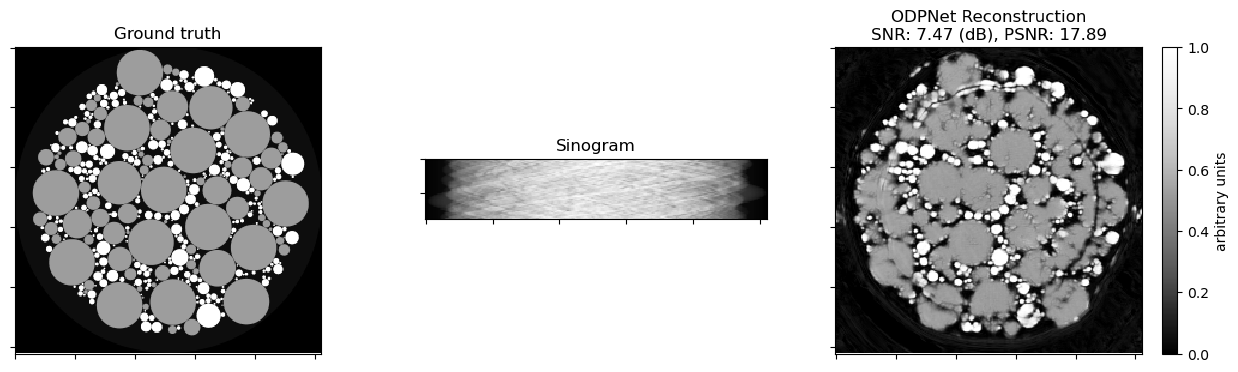

In [12]:
snr_eval = metric.snr(test_ds["label"][:maxn], output)
psnr_eval = metric.psnr(test_ds["label"][:maxn], output)
print(
    f"{'ODPNet training':18s}{'epochs:':2s}{epochs:>5d}{'':21s}{'time[s]:':10s}{time_train:>7.2f}"
)
print(
    f"{'ODPNet testing':18s}{'SNR:':5s}{snr_eval:>5.2f}{' dB'}{'':3s}{'PSNR:':6s}{psnr_eval:>5.2f}{' dB'}{'':3s}{'time[s]:':10s}{time_eval:>7.2f}"
)

# Plot comparison
np.random.seed(123)
indx = np.random.randint(0, high=maxn)

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(test_ds["label"][indx, ..., 0], title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    test_ds["image"][indx, ..., 0],
    title="Sinogram",
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    output[indx, ..., 0],
    title="ODPNet Reconstruction\nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
    ),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics. Statistics only generated if a training cycle was done (i.e. not reading final epoch results from checkpoint).

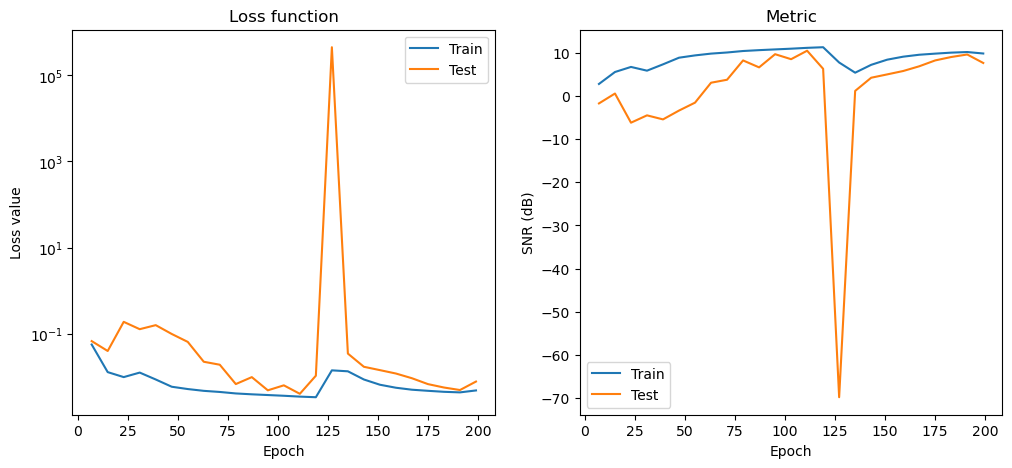

In [13]:
if stats_object is not None:
    hist = stats_object.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        np.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        x=hist.Epoch,
        ptyp="semilogy",
        title="Loss function",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        np.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        x=hist.Epoch,
        title="Metric",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()